In [5]:
import sklearn
import pandas as pd
import numpy as np
from urllib.parse import parse_qsl, urljoin, urlparse

from sklearn.model_selection import cross_val_score 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

pd.set_option('display.max_columns', None) #display all the columns in pandas head function

np.random.seed(42)

import re
import requests
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_predict


random_state = 42
cv_results = np.array([])
cv_means = []
cv_std = []
cvk=10

In [7]:
df =pd.read_csv('Downloads\Submission\malicious_phish.csv')

In [8]:
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [9]:
print(df.shape)

(651191, 2)


In [10]:
df["type"].describe()

count     651191
unique         4
top       benign
freq      428103
Name: type, dtype: object

In [11]:
df["type"].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x29bc233e270>,
 [Text(-0.5220846877148526, 0.9682084377104369, 'Benign'),
  Text(-0.12773036260591056, -1.0925589020590893, 'Defacement'),
  Text(0.7913806562888462, -0.7640135187624859, 'Phishing'),
  Text(1.0864899607286258, -0.1718707806344909, 'Malware')])

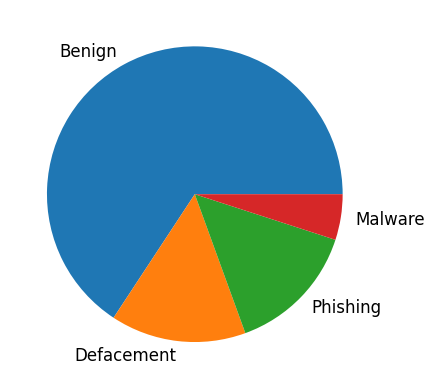

In [12]:
lis=[df["type"].value_counts()[0],df["type"].value_counts()[1],df["type"].value_counts()[2],df["type"].value_counts()[3]]
plt.pie(lis,labels=["Benign","Defacement","Phishing","Malware"])

In [13]:
df["original_url"]=df["url"]

In [14]:
def fix_url(url): #if no protocol (scheme) is used assume the general case of http, this is needed to make the urlparse function works
  if not urlparse(url).scheme:
        return f"http://{url}"
  return url

In [15]:
def get_protocol(url):
  protocol, _, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip() )
  return protocol

In [16]:
def get_host(url):
  _, host, _, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return host

In [17]:
def get_path(url):
  _, _, path, _, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return path

In [18]:
def get_parameters(url):
  _, _, _, parameters, _, _ = urlparse(url.replace("[","").replace("]","").strip())
  return parameters

In [19]:
def get_query(url):
  _, _, _, _, query, _ = urlparse(url.replace("[","").replace("]","").strip())
  return query

In [20]:
def get_fragment(url):
  _, _, _, _, _, fragment = urlparse(url.replace("[","").replace("]","").strip())
  return fragment

In [21]:
df["url"]=df["url"].apply(fix_url)

In [22]:
df

,url,type,original_url
0,http://br-icloud.com.br,phishing,br-icloud.com.br
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...
...,...,...,...
651186,http://xbox360.ign.com/objects/850/850402.html,phishing,xbox360.ign.com/objects/850/850402.html
651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,phishing,games.teamxbox.com/xbox-360/1860/Dead-Space/
651188,http://www.gamespot.com/xbox360/action/deadspace/,phishing,www.gamespot.com/xbox360/action/deadspace/
651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,phishing,en.wikipedia.org/wiki/Dead_Space_(video_game)


In [23]:
df["protocol"]=df["url"].apply(get_protocol)

In [24]:
df["host"]=df["url"].apply(get_host)
df.head()

,url,type,original_url,protocol,host
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net


In [25]:
df["path"]=df["url"].apply(get_path)
df.head()

,url,type,original_url,protocol,host,path
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php


In [26]:
df["parameters"]=df["url"].apply(get_parameters)
df.sample(10)

,url,type,original_url,protocol,host,path,parameters
536448,http://37.49.226.178/deusbins/deus.sh4,malware,http://37.49.226.178/deusbins/deus.sh4,http,37.49.226.178,/deusbins/deus.sh4,
40630,http://medical-dictionary.thefreedictionary.co...,benign,medical-dictionary.thefreedictionary.com/Galt+...,http,medical-dictionary.thefreedictionary.com,/Galt+trephine,
630496,http://www.jscape.com/sshfactory/,phishing,www.jscape.com/sshfactory/,http,www.jscape.com,/sshfactory/,
426724,http://www.wsnc.org.au/component/jcalpro/view/983,defacement,http://www.wsnc.org.au/component/jcalpro/view/983,http,www.wsnc.org.au,/component/jcalpro/view/983,
184034,http://virtualtourist.com/travel/North_America...,benign,virtualtourist.com/travel/North_America/Canada...,http,virtualtourist.com,/travel/North_America/Canada/Province_of_Quebe...,
72922,http://evri.com/person/donald-ballard-0x87e96,benign,evri.com/person/donald-ballard-0x87e96,http,evri.com,/person/donald-ballard-0x87e96,
91279,http://www.sweethome.com.gr/index.php?option=c...,defacement,http://www.sweethome.com.gr/index.php?option=c...,http,www.sweethome.com.gr,/index.php,
618950,http://www.msnbc.msn.com/?id=3475953,phishing,www.msnbc.msn.com/?id=3475953,http,www.msnbc.msn.com,/,
432803,http://www.mruniquespaving.co.uk/paved-drivewa...,defacement,http://www.mruniquespaving.co.uk/paved-drivewa...,http,www.mruniquespaving.co.uk,/paved-driveway-gallery,
171655,http://torcache.net/torrent/4646B1C156C01B1D1B...,benign,http://torcache.net/torrent/4646B1C156C01B1D1B...,http,torcache.net,/torrent/4646B1C156C01B1D1B8FDC82282E80C593890...,


In [27]:
df["query"]=df["url"].apply(get_query)
df.head()

,url,type,original_url,protocol,host,path,parameters,query
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,,
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,,option=com_content&view=article&id=70&vsig70_0=15
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,,option=com_mailto&tmpl=component&link=aHR0cDov...


In [28]:
df["fragment"]=df["url"].apply(get_fragment)

In [29]:
df.head()

,url,type,original_url,protocol,host,path,parameters,query,fragment
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,,,
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,,,
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,,option=com_mailto&tmpl=component&link=aHR0cDov...,


In [30]:
df = df.replace('', np.nan) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651191 non-null  object
 1   type          651191 non-null  object
 2   original_url  651191 non-null  object
 3   protocol      651191 non-null  object
 4   host          651025 non-null  object
 5   path          628145 non-null  object
 6   parameters    325 non-null     object
 7   query         139969 non-null  object
 8   fragment      461 non-null     object
dtypes: object(9)
memory usage: 44.7+ MB


In [31]:
df.drop(['parameters', 'query','fragment'], axis = 1,inplace=True)
df.dropna(subset = ['host'],inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651025 entries, 0 to 651190
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651025 non-null  object
 1   type          651025 non-null  object
 2   original_url  651025 non-null  object
 3   protocol      651025 non-null  object
 4   host          651025 non-null  object
 5   path          627979 non-null  object
dtypes: object(6)
memory usage: 34.8+ MB


In [33]:
df.fillna("",inplace=True)

In [34]:
df.reset_index(drop=True,inplace=True)

In [35]:
def ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['ip_address'] = df['url'].apply(ip_address)

In [36]:
def specialSymbols(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"URL_{symbol}"] = df['url'].apply(lambda i: i.count(symbol))

specialSymbols(df)

In [37]:
def getLength(url):
  return len(url)

In [38]:
df["length"] = df["url"].apply(getLength)

In [39]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['Shortining'] = df['url'].apply(Shortining_Service)

In [40]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [41]:
df['digits_in_url']= df['url'].apply(digit_count)

In [42]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [43]:
df['letters_in_url']= df['url'].apply(letter_count)

In [44]:
def EmailAddress(url):
    if re.findall(r'[\w\.-]+@[\w\.-]+', url):
        return 1
    else:
        return 0

df['email_address']= df['url'].apply(EmailAddress)

In [45]:
def vowels_count(url):
    vowels = ['a', 'e', 'i', 'o', 'u']
    count = 0
    for i in vowels:
        count += url.lower().count(i)
    return count

In [46]:
df['vowels_url']= df['url'].apply(vowels_count)

In [47]:
tld_file = open('Downloads\\Submission\\tld.txt', 'r') #displaying the TLDs list

print(tld_file.readlines() )

tld_file.close()

['AAA\n', 'AARP\n', 'ABB\n', 'ABBOTT\n', 'ABBVIE\n', 'ABC\n', 'ABLE\n', 'ABOGADO\n', 'ABUDHABI\n', 'AC\n', 'ACADEMY\n', 'ACCENTURE\n', 'ACCOUNTANT\n', 'ACCOUNTANTS\n', 'ACO\n', 'ACTOR\n', 'AD\n', 'ADS\n', 'ADULT\n', 'AE\n', 'AEG\n', 'AERO\n', 'AETNA\n', 'AF\n', 'AFL\n', 'AFRICA\n', 'AG\n', 'AGAKHAN\n', 'AGENCY\n', 'AI\n', 'AIG\n', 'AIRBUS\n', 'AIRFORCE\n', 'AIRTEL\n', 'AKDN\n', 'AL\n', 'ALIBABA\n', 'ALIPAY\n', 'ALLFINANZ\n', 'ALLSTATE\n', 'ALLY\n', 'ALSACE\n', 'ALSTOM\n', 'AM\n', 'AMAZON\n', 'AMERICANEXPRESS\n', 'AMERICANFAMILY\n', 'AMEX\n', 'AMFAM\n', 'AMICA\n', 'AMSTERDAM\n', 'ANALYTICS\n', 'ANDROID\n', 'ANQUAN\n', 'ANZ\n', 'AO\n', 'AOL\n', 'APARTMENTS\n', 'APP\n', 'APPLE\n', 'AQ\n', 'AQUARELLE\n', 'AR\n', 'ARAB\n', 'ARAMCO\n', 'ARCHI\n', 'ARMY\n', 'ARPA\n', 'ART\n', 'ARTE\n', 'AS\n', 'ASDA\n', 'ASIA\n', 'ASSOCIATES\n', 'AT\n', 'ATHLETA\n', 'ATTORNEY\n', 'AU\n', 'AUCTION\n', 'AUDI\n', 'AUDIBLE\n', 'AUDIO\n', 'AUSPOST\n', 'AUTHOR\n', 'AUTO\n', 'AUTOS\n', 'AVIANCA\n', 'AW\n', 'AWS\n', 

In [48]:
tld_file = open('Downloads\\Submission\\tld.txt', 'r')
def TLD_count(url):
    tldcount = 0
    tld_list=tld_file.readlines()
    line=0
    while (line < len(tld_list)):
       if tld_list[line].rstrip() in url :
          tldcount+=1
          line+=10
       line+=1
    if(".php" in url):
      tldcount-=1;
    if(".html" in url):
      tldcount-=1;

    tld_file.seek(0)
    return tldcount

df['tld_count']= df['url'].apply(TLD_count)


In [49]:
def check_word_server_client(url):
    if "server" in url.lower() or "client" in url.lower():
        return 1
    return 0
df['server_client']= df['url'].apply(check_word_server_client)

In [50]:
def https(url):
    if str(urlparse(url).scheme)=='https':
        return 1
    else:
        return 0

df['https'] = df['original_url'].apply(https)

In [51]:
def http(url):
    if str(urlparse(url).scheme)=='http':
        return 1
    else:
        return 0

df['http'] = df['original_url'].apply(http)

In [52]:
def ftp(url):
    if str(urlparse(url).scheme)=='ftp':
        return 1
    else:
        return 0

df['ftp'] = df['original_url'].apply(ftp)

In [53]:
def specialSymbols2(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"path_{symbol}"] = df['path'].apply(lambda i: i.count(symbol))

specialSymbols2(df)

In [54]:
df["path_length"] = df["path"].apply(getLength)
df['path_digits_in_url']= df['path'].apply(digit_count)
df['path_letters_in_url']= df['path'].apply(letter_count)
df['path_vowels_url']= df['path'].apply(vowels_count)

In [55]:
def specialSymbols3(df):

  symbolsList = ['_','&','~','"',"'",'@','?','-','=','.','#','%','+','$','!','*',',','//','/',';',':','>','<','^','[',']','{','}','(',')']
  for symbol in symbolsList:
     df[f"host_{symbol}"] = df['host'].apply(lambda i: i.count(symbol))

specialSymbols3(df)

In [56]:
df["host_length"] = df["host"].apply(getLength)
df['host_digits_in_url']= df['host'].apply(digit_count)
df['host_letters_in_url']= df['host'].apply(letter_count)
df['host_vowels_url']= df['host'].apply(vowels_count)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651025 entries, 0 to 651024
Columns: 116 entries, url to host_vowels_url
dtypes: int64(110), object(6)
memory usage: 576.2+ MB


In [58]:
df.head()

,url,type,original_url,protocol,host,path,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
0,http://br-icloud.com.br,phishing,br-icloud.com.br,http,br-icloud.com.br,,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,23,0,0,17,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,13,4
1,http://mp3raid.com/music/krizz_kaliko.html,benign,mp3raid.com/music/krizz_kaliko.html,http,mp3raid.com,/music/krizz_kaliko.html,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,4,0,1,0,0,0,0,0,0,0,0,0,42,0,1,33,0,9,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,24,0,20,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,9,3
2,http://bopsecrets.org/rexroth/cr/1.htm,benign,bopsecrets.org/rexroth/cr/1.htm,http,bopsecrets.org,/rexroth/cr/1.htm,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,5,0,1,0,0,0,0,0,0,0,0,0,38,0,1,29,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,17,1,12,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,13,4
3,http://www.garage-pirenne.be/index.php?option=...,defacement,http://www.garage-pirenne.be/index.php?option=...,http,www.garage-pirenne.be,/index.php,0,2,3,0,0,0,0,1,1,4,3,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,88,0,7,63,0,22,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,8,2,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,18,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,http://adventure-nicaragua.net/index.php?optio...,http,adventure-nicaragua.net,/index.php,0,1,2,0,0,0,0,1,1,3,2,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,235,0,22,199,0,37,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,10,0,8,2,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,0,21,10


In [59]:
df.describe()

,ip_address,URL__,URL_&,URL_~,"URL_""",URL_',URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_!,URL_*,"URL_,",URL_//,URL_/,URL_;,URL_:,URL_>,URL_<,URL_^,URL_[,URL_],URL_{,URL_},URL_(,URL_),length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,https,http,ftp,path__,path_&,path_~,"path_""",path_',path_@,path_?,path_-,path_=,path_.,path_#,path_%,path_+,path_$,path_!,path_*,"path_,",path_//,path_/,path_;,path_:,path_>,path_<,path_^,path_[,path_],path_{,path_},path_(,path_),path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_?,host_-,host_=,host_.,host_#,host_%,host_+,host_$,host_!,host_*,"host_,",host_//,host_/,host_;,host_:,host_>,host_<,host_^,host_[,host_],host_{,host_},host_(,host_),host_length,host_digits_in_url,host_letters_in_url,host_vowels_url
count,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.00000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.0,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.0,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.0,651025.0,651025.00000,651025.000000,651025.000000,651025.000000,651025.000000,651025.0,651025.0,651025.000000,651025.000000,651025.00000,651025.000000,651025.000000,651025.000000,651025.000000,651025.000000
mean,0.019182,0.422945,0.380540,0.013445,0.000058,0.013466,0.00222,0.223804,1.550733,0.603931,2.195332,0.000871,0.519604,0.068447,0.000238,0.000954,0.000395,0.004825,1.003749,4.372863,0.038865,1.053559,0.000075,0.000078,0.000129,0.002416,0.002416,0.000284,0.000289,0.006083,0.006066,65.136566,0.061051,5.527164,48.093107,0.001676,15.254844,-0.031366,0.004094,0.024085,0.264686,0.000003,0.286123,0.003359,0.013310,0.000003,0.002625,0.000885,0.0,1.284192,0.009258,0.509882,0.0,0.378205,0.045324,0.000078,0.000484,0.000178,0.004049,0.001528,2.317032,0.001045,0.004805,0.000015,0.000017,0.000023,0.0,0.0,0.000008,0.000017,0.005650,0.005645,28.784928,3.057864,20.848093,7.151069,0.000198,0.000028,0.000026,0.000040,0.006027,0.000029,0.0,0.133457,0.000026,1.599343,0.0,0.000149,0.000041,0.000022,0.000029,0.000031,0.0,0.0,0.0,0.00002,0.007668,0.000026,0.000026,0.000040,0.0,0.0,0.000029,0.000025,0.00002,0.000029,17.396748,0.632363,15.015024,5.347429
std,0.137165,1.173656,1.224219,0.117716,0.011359,0.161294,0.05419,0.441239,2.974074,1.517055,1.490828,0.032331,4.462810,0.621353,0.023547,0.039551,0.074948,0.152447,0.068602,1.650435,0.558549,0.302824,0.014821,0.014293,0.018299,0.050240,0.050025,0.018753,0.018794,0.083838,0.083573,43.662721,0.239425,11.701532,31.057570,0.040902,10.265188,1.328421,0.063850,0.153314,0.441166,0.001753,1.067898,0.105468,0.116499,0.001753,0.053459,0.032591,0.0,2.874548,0.141740,0.695815,0.0,3.755854,0.508936,0.010443,0.029194,0.068312,0.142917,0.039533,1.566967,0.057458,0.086552,0.006072,0.006197,0.007539,0.0,0.0,0.002771,0.004469,0.080026,0.080016,27.999202,7.077647,19.804190,7.349687,0.015822,0.006072,0

In [60]:
df.drop(["path_?","path_#","path_[","path_]","host_?","host_#","host_,","host_//","host_/","host_[","host_]",],axis=1,inplace=True)

In [61]:
df.drop(["protocol"],axis=1,inplace=True)

In [62]:
df.drop(["url","path","host","original_url"],axis=1,inplace=True)

In [63]:
df["host_><^{}()!;:~"]=df["host_<"]+df["host_>"]+df["host_^"]+df["host_}"] +df["host_{"]+df["host_("] +df["host_)"]+df["host_!"]+df["host_;"]+df["host_:"]+df["host_~"]
df.drop(["host_<","host_>","host_^","host_}","host_{","host_(","host_)","host_!","host_:","host_;"],axis=1,inplace=True)

In [64]:
df["path_><^{}()!;:'~"]=df["path_<"]+df["path_>"]+df["path_^"]+df["path_}"] +df["path_{"]+df["path_("] +df["path_)"]+df["path_!"]+df["path_;"]+df["path_:"]+df["path_'"]+df['path_"']+df['path_~']
df.drop(["path_<","path_>","path_^","path_}","path_{","path_(","path_)","path_!","path_:","path_;",'path_"',"path_'",'path_~'],axis=1,inplace=True)

In [65]:
df["URL_><^{}()[]!;:'~"]=df["URL_<"]+df["URL_>"]+df["URL_^"]+df["URL_}"] +df["URL_{"]+df["URL_("] +df["URL_)"]+df["URL_["]+df["URL_]"]+df["URL_!"]+df["URL_;"]+df["URL_:"]+df["URL_'"]+df['URL_"']+df['URL_~']
df.drop(["URL_<","URL_>","URL_^","URL_}","URL_{","URL_(","URL_)","URL_!","URL_:","URL_;","URL_[","URL_]","URL_'",'URL_"','URL_~'],axis=1,inplace=True)

In [66]:
df['https+ftp']=df['https']+df['ftp']
df.drop(["https","ftp"],axis=1,inplace=True)

In [67]:
df["type"] = df["type"].astype('category')
df["type"] = df["type"].cat.codes

In [68]:
types=pd.DataFrame()
types["type"]=df["type"].copy()
df.drop(["type"],axis=1,inplace=True)

In [69]:
columns=df.columns

In [70]:
from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
df=stdScaler.fit_transform(df)

In [71]:
df=pd.DataFrame(df,columns=columns)

In [72]:
df.describe()

,ip_address,URL__,URL_&,URL_@,URL_?,URL_-,URL_=,URL_.,URL_#,URL_%,URL_+,URL_$,URL_*,"URL_,",URL_//,URL_/,length,Shortining,digits_in_url,letters_in_url,email_address,vowels_url,tld_count,server_client,http,path__,path_&,path_@,path_-,path_=,path_.,path_%,path_+,path_$,path_*,"path_,",path_//,path_/,path_length,path_digits_in_url,path_letters_in_url,path_vowels_url,host__,host_&,host_~,"host_""",host_',host_@,host_-,host_=,host_.,host_%,host_+,host_$,host_*,host_length,host_digits_in_url,host_letters_in_url,host_vowels_url,host_><^{}()!;:~,path_><^{}()!;:'~,URL_><^{}()[]!;:'~,https+ftp
count,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05,6.510250e+05
mean,6.810471e-17,3.667177e-18,5.029271e-17,-5.719049e-18,1.536722e-17,-6.286588e-18,1.501796e-17,-8.731373e-18,-5.413451e-18,-1.789931e-17,-1.885976e-17,2.051873e-18,6.875956e-19,-8.775030e-18,9.573077e-16,-1.589110e-17,1.459886e-16,4.453000e-17,-1.222392e-17,4.156133e-17,4.453000e-18,-8.626596e-17,-1.344631e-17,2.307265e-17,-4.330761e-17,-7.788384e-17,3.972775e-18,1.373008e-17,5.168973e-17,5.980990e-18,3.806878e-17,-1.589110e-17,2.898816e-17,8.021949e-19,-9.604510e-19,-3.689005e-18,2.706726e-18,-8.678984e-17,-1.257318e-17,5.937333e-18,-3.300459e-17,-1.362094e-17,1.082690e-17,5.271566e-18,-1.527990e-19,-1.817217e-18,-2.534281e-17,-3.328836e-19,4.592702e-17,9.768223e-19,-1.920902e-17,-1.462505e-18,-6.368445e-18,6.652215e-18,1.347906e-18,1.907368e-16,1.938365e-17,3.754490e-17,-5.168973e-17,-2.287620e-17,-1.606573e-17,2.605769e-17,3.125831e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.398471e-01,-3.603660e-01,-3.108432e-01,-4.095893e-02,-5.072171e-01,-5.214175e-01,-3.980946e-01,-1.472560e+00,-2.693818e-02,-1.164298e-01,-1.101588e-01,-1.011117e-02,-5.267176e-03,-3.164841e-02,-5.465569e-02,-1.437721e+00,-1.308590e+00,-2.549922e-01,-4.723457e-01,-1.419723e+00,-4.097111e-02,-1.486077e+00,-1.481937e+00,-6.411217e-02,-5.999689e-01,-2.679308e-01,-3.185159e-02,-2.714755e-02,-4.467459e-01,-6.531482e-02,-7.327847e-01,-1.006976e-01,-8.905626e-02,-7.501608e-03,-2.608355e-03,-2.833116e-02,-3.865997e-02,-1.478674e+00,-1.028063e+00,-4.320456e-01,-1.052712e+00,-9.729768e-01,-1.252366e-02,-4.553785e-03,-4.597747e-03,-4.231208e-03,-7.781166e-02,-4.709660e-03,-2.577198e-01,-4.833685e-03,-1.497848e+00,-2.117599e-03,-4.780484e-03,-4.089748e-03,-4.525588e-03,-1.450132e+00,-1.717679e-01,-1.775181e+00,-1.691166e+00,-8.265480e-02,-1.425505e-01,-1.897058e-01,-1.571074e-01
25%,-1.398471e-01,-3

In [73]:
df["type"]=types["type"]

In [74]:
from sklearn.model_selection import train_test_split

y = df["type"]
X = df.drop(labels = ["type"], axis =1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [75]:
y_test.describe()

count    130205.000000
mean          0.686756
std           1.090876
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [76]:
y_train.describe()

count    520820.000000
mean          0.680316
std           1.087427
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [77]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df["type"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

X_train =  strat_train_set.drop("type",axis=1)
y_train =  strat_train_set["type"]
X_test  =   strat_test_set.drop("type",axis=1)
y_test  =   strat_test_set["type"]

In [78]:
y_test.describe()

count    195308.000000
mean          0.681611
std           1.088127
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [79]:
y_train.describe()

count    455717.000000
mean          0.681601
std           1.088118
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: type, dtype: float64

In [80]:
df.columns

Index(['ip_address', 'URL__', 'URL_&', 'URL_@', 'URL_?', 'URL_-', 'URL_=',
       'URL_.', 'URL_#', 'URL_%', 'URL_+', 'URL_$', 'URL_*', 'URL_,', 'URL_//',
       'URL_/', 'length', 'Shortining', 'digits_in_url', 'letters_in_url',
       'email_address', 'vowels_url', 'tld_count', 'server_client', 'http',
       'path__', 'path_&', 'path_@', 'path_-', 'path_=', 'path_.', 'path_%',
       'path_+', 'path_$', 'path_*', 'path_,', 'path_//', 'path_/',
       'path_length', 'path_digits_in_url', 'path_letters_in_url',
       'path_vowels_url', 'host__', 'host_&', 'host_~', 'host_"', 'host_'',
       'host_@', 'host_-', 'host_=', 'host_.', 'host_%', 'host_+', 'host_$',
       'host_*', 'host_length', 'host_digits_in_url', 'host_letters_in_url',
       'host_vowels_url', 'host_><^{}()!;:~', 'path_><^{}()!;:'~',
       'URL_><^{}()[]!;:'~', 'https+ftp', 'type'],
      dtype='object')

In [81]:
model_DT=DecisionTreeClassifier(random_state=random_state)

scores=cross_val_score(model_DT, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

array([0.92953501, 0.92517246, 0.92727697, 0.92472858, 0.92654088,
       0.92641231, 0.92734365, 0.92569456, 0.92500921, 0.92879343])

In [82]:
scores

array([0.92953501, 0.92517246, 0.92727697, 0.92472858, 0.92654088,
       0.92641231, 0.92734365, 0.92569456, 0.92500921, 0.92879343])

In [83]:
model_DT=DecisionTreeClassifier(random_state=random_state) # you dont have to run the above cell to diplay the confucsion matrix, only this one.
results_DT=cross_val_predict(model_DT,X_train,y_train,cv=cvk)


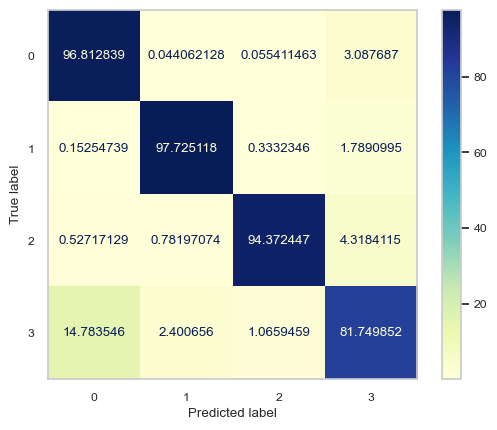

In [84]:
cm = confusion_matrix(y_train , results_DT, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("DT_cm.png",bbox_inches='tight' )

In [85]:
print(classification_report(y_train,results_DT))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    299577
           1       0.97      0.98      0.97     67520
           2       0.95      0.94      0.95     22763
           3       0.82      0.82      0.82     65857

    accuracy                           0.95    455717
   macro avg       0.93      0.93      0.93    455717
weighted avg       0.95      0.95      0.95    455717



In [86]:
random_state = 42

model_RF=RandomForestClassifier(random_state=random_state)

scores=cross_val_score(model_RF, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

array([0.94197977, 0.93955631, 0.94188276, 0.9381844 , 0.94083744,
       0.93920219, 0.94231344, 0.93921166, 0.93871179, 0.94143474])

In [87]:
model_RF=RandomForestClassifier(random_state=random_state)

results_RF=cross_val_predict(model_RF,X_train,y_train,cv=cvk)

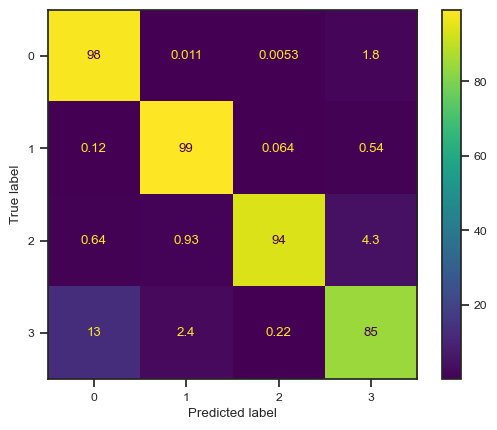

In [88]:
cm = confusion_matrix(y_train , results_RF, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) 
sns.set(font_scale=0.8 )
sns.set_style("ticks", {'axes.grid': False})
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="viridis" )

plt.savefig("RF_cm.png",bbox_inches='tight')

In [89]:
print(classification_report(y_train,results_RF))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    299577
           1       0.97      0.99      0.98     67520
           2       0.99      0.94      0.97     22763
           3       0.89      0.85      0.87     65857

    accuracy                           0.96    455717
   macro avg       0.96      0.94      0.95    455717
weighted avg       0.96      0.96      0.96    455717



In [90]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print("accuracy = " + str (accuracy_score(y_train,results_RF)))
print("precision = " + str (precision_score(y_train,results_RF,average="macro")))
print("recall = " + str (recall_score(y_train,results_RF,average="macro")))
print("F1 = " + str (f1_score(y_train,results_RF,average="macro")))
#print("FPR = " + str (FPR.mean()))

accuracy = 0.9616801655413337
precision = 0.9568467901332082
recall = 0.9403313387726083
F1 = 0.9482450233003539


In [91]:
random_state = 42

model_LR=LogisticRegression(random_state=random_state)

scores=cross_val_score(model_LR, X_train, y = y_train, scoring = "recall_macro", cv = cvk, n_jobs=-1)
cv_means.append(scores.mean())
cv_std.append(scores.std())
np.append(scores,cv_results,axis=0)

array([0.73214758, 0.73102179, 0.72863531, 0.72755254, 0.72578475,
       0.73074368, 0.73427739, 0.72926294, 0.73206311, 0.7304036 ])

In [92]:
model_LR=LogisticRegression(random_state=random_state)

results_LR=cross_val_predict(model_LR,X_train,y_train,cv=cvk)

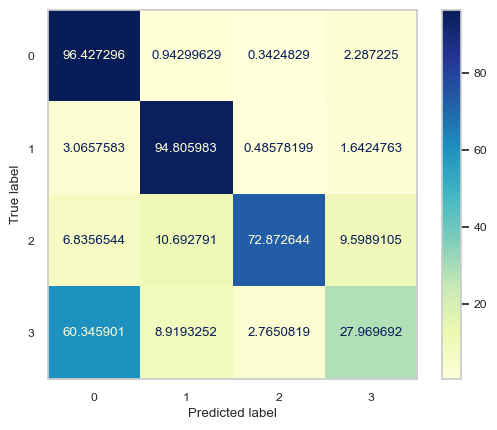

In [93]:
cm = confusion_matrix(y_train , results_LR, )
ncm=cm  /(cm.sum(axis=1,keepdims=True)) #normalizing the confusion matrix
sns.set(font_scale=0.8 )
sns.set_style("whitegrid", {'axes.grid' : False})
#np.fill_diagonal(ncm,0)
disp = ConfusionMatrixDisplay(confusion_matrix=ncm*100 )
disp.plot(cmap="YlGnBu" ,values_format = '.8g')

plt.savefig("LR_cm.png",bbox_inches='tight')

In [94]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree",
"RandomForest","LogisticRegression"]})

In [95]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


In [96]:
inplace=True
temp=cv_res

In [97]:
temp

,CrossValMeans,CrossValerrors,Algorithm
0,0.926651,0.001528,DecisionTree
1,0.940331,0.001445,RandomForest
2,0.730189,0.002339,LogisticRegression


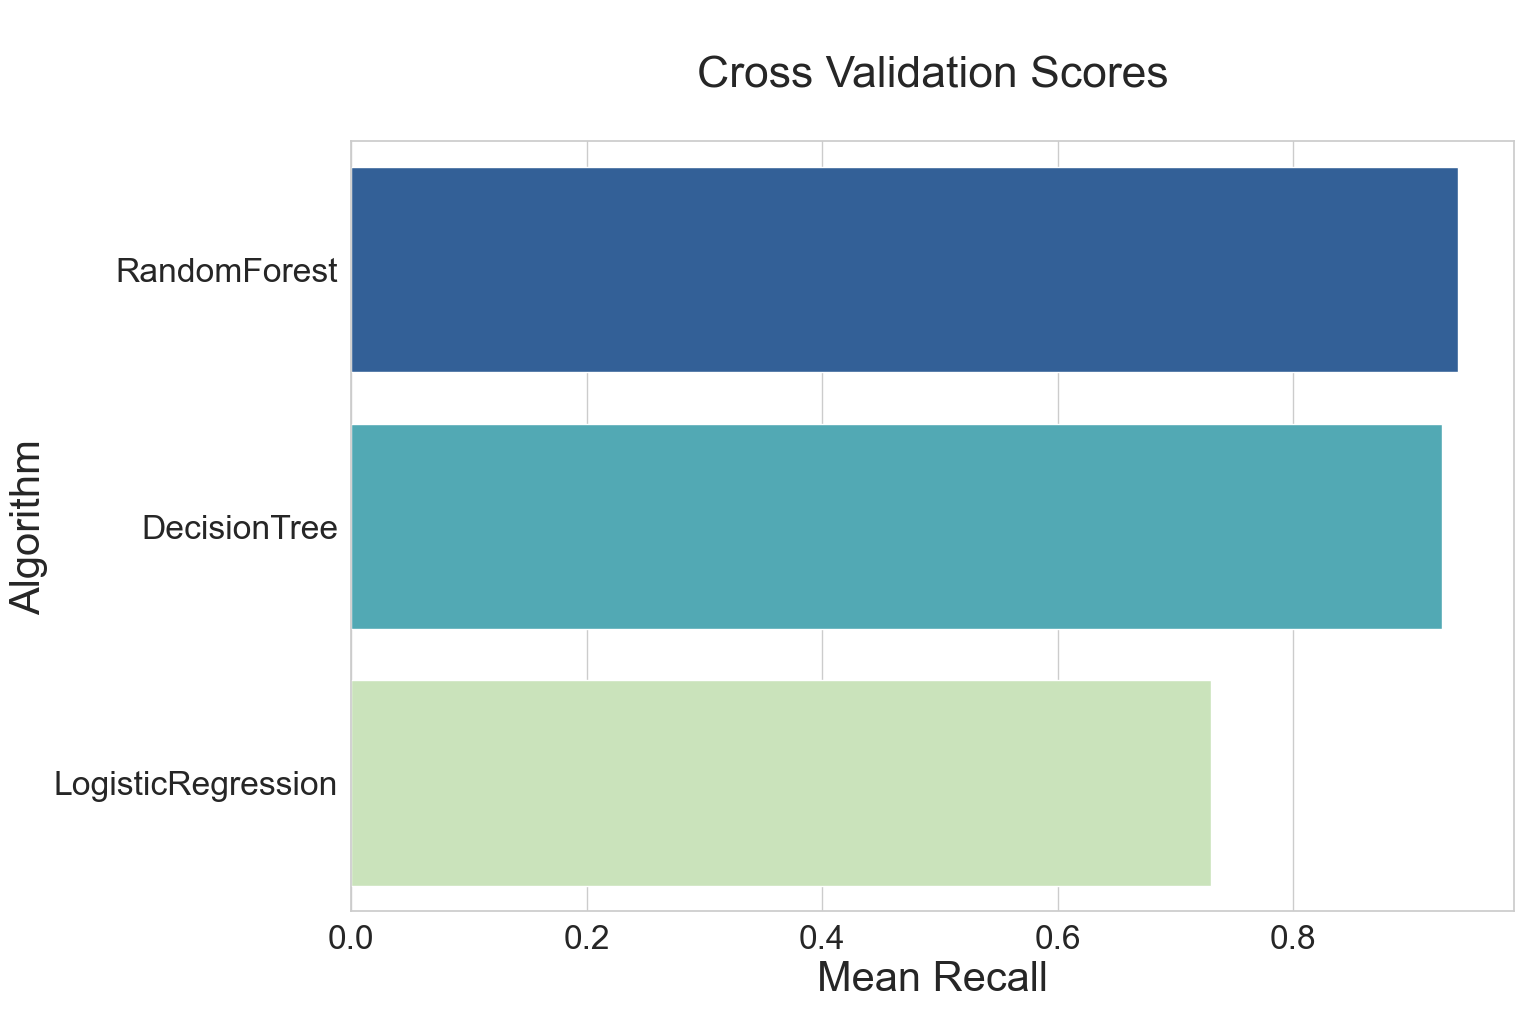

In [98]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=2.2)
sns.set_style("whitegrid")

# Make sure 'temp' is a Pandas DataFrame with 'CrossValMeans' and 'Algorithm' columns
# Assuming 'temp' has already been defined in your environment

# Sort the dataframe
sorted_temp = temp.sort_values(["CrossValMeans"], ascending=False)

# Create the barplot
g = sns.barplot(x="CrossValMeans", y="Algorithm", data=sorted_temp, palette="YlGnBu_r", orient="h")
g.set_xlabel("Mean Recall", fontsize=30)
g.set_ylabel("Algorithm", fontsize=30)
g.set_title("\nCross Validation Scores\n", fontsize=32)

# Save the figure
plt.savefig("all_score.png", bbox_inches='tight')